# Deep Learning HW 4: Fine-tuning Pre-trained Models
Akwasi D. Akwaboah <br>
04/27/2021

**Load LFW Dataset**

In [1]:
import numpy as np

np.random.seed(42)

from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset='train', resize=1, color = True, slice_ = (slice(12, 239, None), slice(12, 239, None)))
lfw_pairs_test = fetch_lfw_pairs(subset='test', resize=1, color = True, slice_ = (slice(12, 239, None), slice(12, 239, None)))
# lfw_pairs_val = fetch_lfw_pairs(subset='10_folds', resize=1.4, color = True, slice_ = (slice(45, 205, None), slice(45, 205, None)))

**Sample plot**

(2, 227, 227, 3)


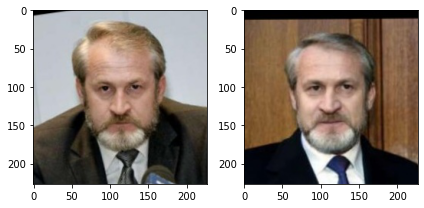

In [2]:
import matplotlib.pyplot as plt
print(lfw_pairs_train.pairs[0].shape)
idx = 20
plt.figure()
plt.subplot(1,2,1)
plt.imshow(lfw_pairs_train.pairs[idx,0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(lfw_pairs_train.pairs[idx,1].astype('uint8'))
plt.tight_layout()
plt.show()

## AlexNet feature Extractor

In [5]:
cd /content/drive/MyDrive/DL_HW4

/content/drive/MyDrive/DL_HW4


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from alexnet import AlexNet


IMG_SHAPE = (227, 227, 3)

#create siamese network
def tf_siamese_nn(shape, fineTune=False):
  
    base_model = AlexNet()
    base_model.summary()
    
    if fineTune==False:
        base_model.trainable=False
    else:
        base_model.trainable = True
        # Fine-tune from this layer onwards
        fine_tune_at = len(base_model.layers) - int(len(base_model.layers)*.10)
        print(fine_tune_at)
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False
    model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    
    return model

#distance metric
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


In [7]:

img1 = keras.layers.Input(shape=IMG_SHAPE)
img2 =  keras.layers.Input( shape=IMG_SHAPE)
featureExtractor = tf_siamese_nn(IMG_SHAPE)
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)
# finally, construct the siamese network
distance = keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = keras.layers.Dense(1, activation="softmax")(distance)
model_nft = keras.Model(inputs=[img1, img2], outputs=outputs)
model_nft.summary()

model_nft.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

AlexNet created.
Weights loaded.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 57, 57, 96)   34944       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 57, 57, 96)   384         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 57, 57, 96)   0           batch_normalization[0][0]        
_____________________________________________________________

**Inference - Without fine tuning**

In [8]:
test_pairA = lfw_pairs_test.pairs[:,0].reshape(lfw_pairs_test.target.shape[0],227,227,3)
test_pairB = lfw_pairs_test.pairs[:,1].reshape(lfw_pairs_test.target.shape[0],227,227,3)

preds = model_nft.predict( [test_pairA , test_pairB])
print(preds[0:10])
print(lfw_pairs_test.target[0:10])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1 1 1 1 1 1 1 1 1 1]


______________Positive Pairs :Same_______________


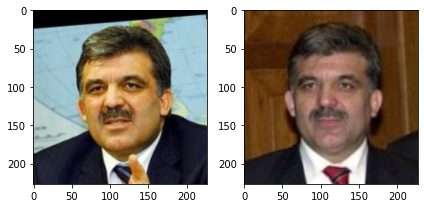

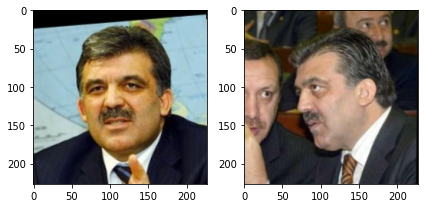

______________Negative Pairs :Different_______________


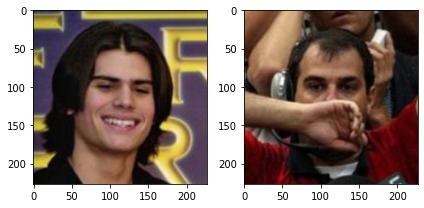

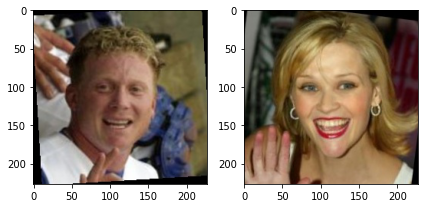

In [9]:
import numpy as np

idx_0 = np.where(lfw_pairs_test.target==0)[0]
idx_1 = np.where(lfw_pairs_test.target==1)[0]

print('______________Positive Pairs :Same_______________')
for i in range(2):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(lfw_pairs_test.pairs[idx_1[i],0].astype('uint8'))
  plt.subplot(1,2,2)
  plt.imshow(lfw_pairs_test.pairs[idx_1[i],1].astype('uint8'))
  plt.tight_layout()
  plt.show()

print('______________Negative Pairs :Different_______________')
for i in range(2):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(lfw_pairs_test.pairs[idx_0[i],0].astype('uint8'))
  plt.subplot(1,2,2)
  plt.imshow(lfw_pairs_test.pairs[idx_0[i],1].astype('uint8'))
  plt.tight_layout()
  plt.show()

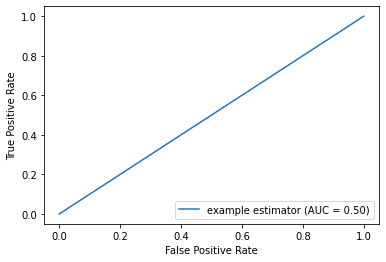

In [10]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import metrics
import pickle

class roc_metrics:
  fpr_i = 0
  tpr_i = 0
  thresh_i = 0

y = lfw_pairs_test.target
fpr_nft, tpr_nft, thresholds_nft = metrics.roc_curve(y, preds)
# print(thresholds)
roc_auc = metrics.auc(fpr_nft, tpr_nft)
roc_cont = roc_metrics
roc_cont.fpr_i = fpr_nft
roc_cont.tpr_i = tpr_nft
roc_cont.thresh_i = thresholds_nft
display = metrics.RocCurveDisplay(fpr=fpr_nft, tpr=tpr_nft, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()  
plt.show()

pickle.dump(roc_cont,open('VGG_con.pickle', 'wb'))

In [11]:
# A = pickle.load(open('Alx_con.pickle', 'rb'))
# A.thresh_i

### Fine-Tuning

In [12]:
#create verification model using siamese network;
img1 = keras.layers.Input(shape=IMG_SHAPE)
img2 =  keras.layers.Input( shape=IMG_SHAPE)
featureExtractor = tf_siamese_nn(IMG_SHAPE, fineTune=True)
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)
# finally, construct the siamese network
distance = keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
model_ft = keras.Model(inputs=[img1, img2], outputs=outputs)
model_ft.summary()
# opt = keras.optimizers.Adam(lr=0.001)
# model_ft.compile(loss=contrastive_loss, optimizer=opt,metrics=["accuracy"])
model_ft.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

AlexNet created.
Weights loaded.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 57, 57, 96)   34944       input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 57, 57, 96)   384         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_2 (ReLU)                  (None, 57, 57, 96)   0           batch_normalization_2[0][0]      
___________________________________________________________

In [13]:
#Training the model
train_pair_A = lfw_pairs_train.pairs[:,0].reshape(lfw_pairs_train.target.shape[0],227,227,3)
train_pair_B = lfw_pairs_train.pairs[:,1].reshape(lfw_pairs_train.target.shape[0],227,227,3)

history = model_ft.fit([train_pair_A, train_pair_B], lfw_pairs_train.target[:], validation_split=0.2 ,batch_size=1, epochs=50)
model_ft.save("fineTune_AlxModel_10.h5")
print("Saved model to disk")

Epoch 1/50
1760/1760 [==============================] - 18s 10ms/step - loss: 17.4074 - accuracy: 0.3955 - val_loss: 0.4587 - val_accuracy: 0.8000
Epoch 2/50
1760/1760 [==============================] - 16s 9ms/step - loss: 0.6732 - accuracy: 0.6037 - val_loss: 0.5970 - val_accuracy: 0.6273
Epoch 3/50
1760/1760 [==============================] - 16s 9ms/step - loss: 0.6066 - accuracy: 0.6882 - val_loss: 0.6600 - val_accuracy: 0.5455
Epoch 4/50
1760/1760 [==============================] - 16s 9ms/step - loss: 0.5239 - accuracy: 0.7696 - val_loss: 0.5880 - val_accuracy: 0.6477
Epoch 5/50
1760/1760 [==============================] - 16s 9ms/step - loss: 0.4511 - accuracy: 0.8326 - val_loss: 0.6268 - val_accuracy: 0.6023
Epoch 6/50
1760/1760 [==============================] - 16s 9ms/step - loss: 0.3713 - accuracy: 0.8790 - val_loss: 0.6049 - val_accuracy: 0.6273
Epoch 7/50
1760/1760 [==============================] - 16s 9ms/step - loss: 0.2934 - accuracy: 0.9144 - val_loss: 0.5934 - val_

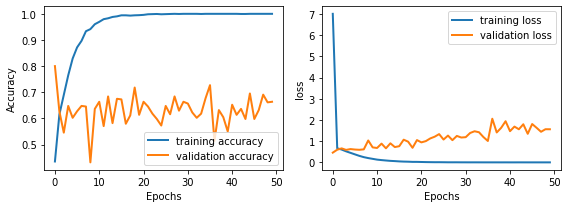

In [19]:
from sklearn.metrics import classification_report 
# print(classification_report(np.ravel(y), np.ravel(preds))) #np.ravel(preds)))

plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'],linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'], loc='best')
plt.tight_layout()

In [20]:
test_pairA = lfw_pairs_test.pairs[:,0].reshape(lfw_pairs_test.target.shape[0],227,227,3)
test_pairB = lfw_pairs_test.pairs[:,1].reshape(lfw_pairs_test.target.shape[0],227,227,3)

model_ft.evaluate([test_pairA , test_pairB], lfw_pairs_test.target, batch_size = 2)
preds = model_ft.predict([test_pairA , test_pairB])
print(preds[0:10])
print(lfw_pairs_test.target[0:10])

500/500 [==============================] - 3s 6ms/step - loss: 2.5031 - accuracy: 0.6030
[[9.74204600e-01]
 [6.58250391e-01]
 [2.41466865e-01]
 [9.90618765e-01]
 [9.98038113e-01]
 [9.47674155e-01]
 [9.92304385e-01]
 [1.97397657e-02]
 [1.47317285e-02]
 [4.73609136e-04]]
[1 1 1 1 1 1 1 1 1 1]


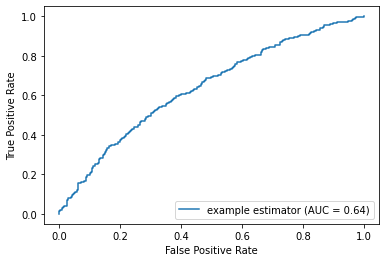

In [21]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import metrics
import pickle

class roc_metrics:
  fpr_i = 0
  tpr_i = 0
  thresh_i = 0

y = lfw_pairs_test.target
fpr_ft, tpr_ft, thresholds_ft = metrics.roc_curve(y, preds)
roc_cont = roc_metrics
roc_cont.fpr_i = fpr_ft
roc_cont.tpr_i = tpr_ft
roc_cont.thresh_i = thresholds_nft
roc_auc = metrics.auc(fpr_ft, tpr_ft)
display = metrics.RocCurveDisplay(fpr=fpr_ft, tpr=tpr_ft, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()  
plt.show()
pickle.dump(roc_cont,open('VGG_P1.pickle', 'wb'))